In [15]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn import cluster
from sklearn import mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

In [7]:
# 
n_samples = 1500
noise_circels = datasets.make_circles(n_samples = n_samples, factor = 0.5, noise = 0.05)
noise_moons = datasets.make_moons(n_samples = n_samples, noise = 0.05)
blobs = datasets.make_blobs(n_samples = n_samples, random_state = 8)
no_structure = np.random.rand(n_samples, 2), None


# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples = n_samples, random_state = random_state)
transformation = [[0.6, -0.6],
                  [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples = n_samples, cluster_std = [1.0, 2.5, 0.5], random_state = random_state)

In [12]:
# cluser parameters
default_base = {
    'quantile': 0.3,
    'eps': 0.3,
    'damping': 0.9,
    'preference': -200,
    'n_neighbors': 10,
    'n_clusters': 3
}

dataset = [
    (noise_circels, {'damping': 0.77, 'preference': -240, 'quantile': 0.2, 'n_clusters': 2}),
    (noise_moons, {'damping': 0.75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': 0.18, 'n_neighbors': 2}),
    (aniso, {'eps': 0.15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})
]

In [17]:
plt.figure(figsize = (9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left = 0.02, right = 0.98, bottom = 0.001, top = 0.96, 
                    wspace = 0.05, hspace = 0.01)

for i_dataset, (dataset, algo_params) in enumerate(dataset):
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    
    bandwidth = cluster.estimate_bandwidth(X, quantile = params['quantile'])
    
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors = params['n_neighbors'], include_self = False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ms = cluster.MeanShift(bandwidth = bandwidth, bin_seeding = True)
    
    two_means = cluster.MiniBatchKMeans(n_clusters = params['n_clusters'])
    ward = cluster.AgglomerativeClustering(n_clusters = params['n_clusters'], linkage = 'ward', connectivity = connectivity)
    average_linkage = cluster.AgglomerativeClustering(n_clusters = params['n_clusters'], linkage = 'average', affinity = 'cityblock')
    complete_linkage = cluser.AgglomerativeClustering(n_clusters = params['n_clusters'], linkage = 'complete')
    single_linkage = cluser.AgglomerativeClustering(n_clusters = params['n_clusters'], linkage = 'single')
    spectral = cluster.SpectralClustering(n_clusters = params['n_cluster'], eigen_solver = 'arpack', affinity = 'nearest_neighbors')
    dbscan = cluster.DBSCAN(eps = params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping = params['damping'], preference = params['preference'])
    birch = cluster.Birch(n_clusters = params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components = params['n_clusters'], covariance_type = 'full')
    
    clustering_algorithms = {
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', aff),
        (),()
        (),
        (),
        (),
        (),
        (),
        (),
    }
    

ValueError: too many values to unpack (expected 2)

<Figure size 986.4x1044 with 0 Axes>

### 聚类算法详解

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics.pairwise import pairwise_distances_argmin

### 数据

In [19]:
centers = [[1, 1], 
           [-1, -1], 
           [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 3000, centers = centers, cluster_std = 0.7)
print(X.shape)
print(labels_true)

(3000, 2)
[1 1 2 ... 2 1 0]


### KMeans

In [22]:
k_means = KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, max_iter = 300)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Mini-Batch KMeans

In [23]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters = n_clusters, init = 'k-means++', batch_size = 45, n_init = 10, max_no_improvement = 10, verbose = 0)
mini_batch_kmeans.fit(X)

MiniBatchKMeans(batch_size=45, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

### Brich

In [26]:
brich_without_global = Birch(threshold = 1.7, n_clusters = None)
brich_without_global.fit(X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
   threshold=1.7)

In [30]:
brich_with_global = Birch(threshold = 1.7, n_clusters = n_clusters)
brich_with_global.fit(X)

D:\Anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
   threshold=1.7)

### 结果展示及比较

In [41]:
k_means_labels_pred = k_means.labels_
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis = 0)

mini_batch_kmeans_labels_pred = mini_batch_kmeans.labels_
mini_batch_kmeans_cluster_centers = np.sort(mini_batch_kmeans.cluster_centers_, axis = 0)

brich_without_global_labels_pred = brich_without_global.labels_
brich_without_global_cluster_centers = np.sort(brich_without_global.subcluster_centers_ , axis = 0)

brich_with_global_labels_pred = brich_with_global.labels_
brich_with_global_cluster_centers = np.sort(brich_with_global.subcluster_centers_ , axis= 0)

print(k_means_labels_pred)
print(mini_batch_kmeans_labels_pred)
print(brich_without_global_labels_pred)
print(brich_with_global_labels_pred)

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mini_batch_kmeans_labels = pairwise_distances_argmin(X, mini_batch_kmeans_cluster_centers)
brich_without_global_labels = pairwise_distances_argmin(X, brich_without_global_cluster_centers)
brich_with_global_labels = pairwise_distances_argmin(X, brich_with_global_cluster_centers)


[0 1 0 ... 1 1 2]
[1 1 2 ... 1 1 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


IndexError: index 2 is out of bounds for axis 0 with size 2

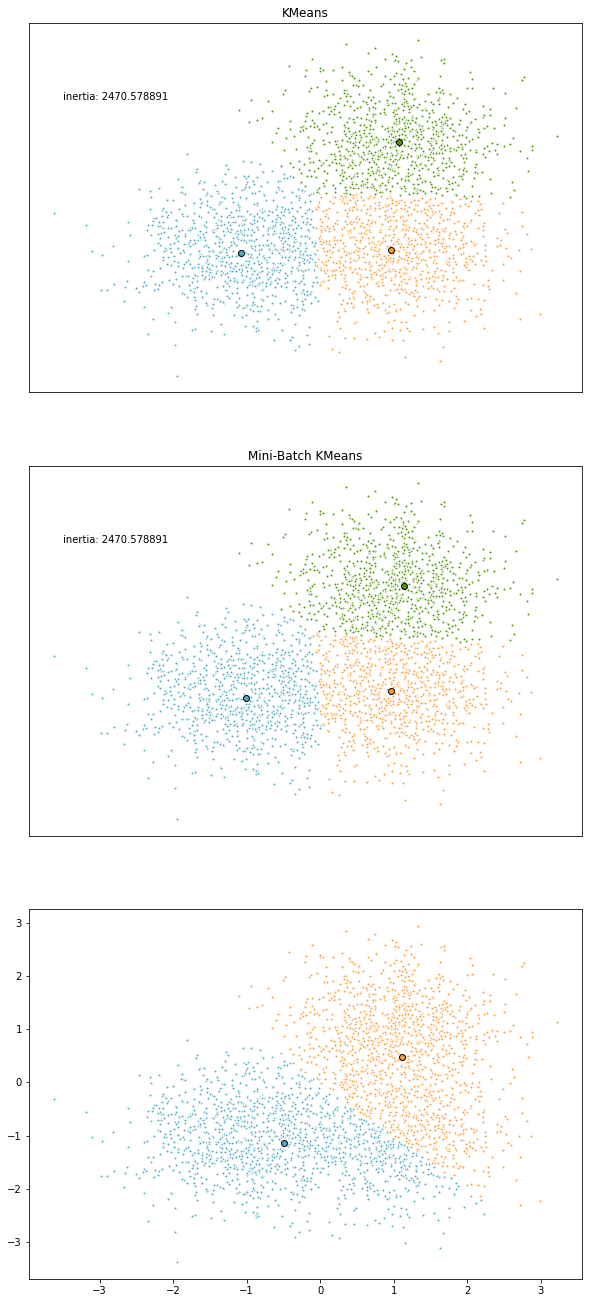

In [48]:
fig = plt.figure(figsize = (8, 35))
fig.subplots_adjust(left = 0.02, right = 0.98, bottom = 0.05, top = 0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

def plot_clustering(i, labels, cluster_centers, title, model):
    ax = fig.add_subplot(5, 1, i)
    for k, col in zip(range(n_clusters), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor = col, marker = '.')
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor = col, markeredgecolor = 'k', markersize = 6)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
    plt.text(-3.5, 1.8, 'inertia: %f' % model.inertia_)

plot_clustering(1, k_means_labels, k_means_cluster_centers, "KMeans", k_means)
plot_clustering(2, mini_batch_kmeans_labels, mini_batch_kmeans_cluster_centers, "Mini-Batch KMeans", k_means)
plot_clustering(3, brich_without_global_labels, brich_without_global_cluster_centers, "Brich without global", brich_without_global)
plot_clustering(4, brich_with_global_labels, brich_with_global_cluster_centers, "Brich with global", brich_with_global)